In [21]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from scipy.stats import norm, t
import warnings
warnings.filterwarnings('ignore')

print("Downloading data...")
tickers = ['LMT', 'RTX', 'NOC', 'GD', 'BA', 'LHX', 'HII', 'TDG', 'TXT', 'CW', 'HEI']

try:
    data = yf.download(tickers, start='2020-01-01', end='2025-01-01', progress=False)
    
    if isinstance(data.columns, pd.MultiIndex):
        close_data = data['Close']
    else:
        close_data = data
    
    if len(tickers) == 1:
        close_data = pd.DataFrame(close_data)
        close_data.columns = tickers
    
    close_data = close_data[tickers]
    
except Exception as e:
    print(f"Error downloading data: {e}")
    raise

returns = np.log(close_data / close_data.shift(1)).dropna()

In [22]:
market_caps = np.array([120, 110, 70, 75, 115, 40, 10, 45, 20, 9, 8])
weights = market_caps / market_caps.sum()
portfolio_returns = returns.dot(weights)

confidence_level = 0.95
alpha = 1 - confidence_level

In [23]:
def calculate_var_es(returns, alpha=0.05, method='historical'):
    if method == 'historical':
        var = -np.percentile(returns, 100 * alpha)
        es = -returns[returns <= -var].mean()
    
    elif method == 'parametric':
        mean_ret = returns.mean()
        std_ret = returns.std()
        var = -(mean_ret + std_ret * norm.ppf(alpha))
        es = -(mean_ret + std_ret * norm.pdf(norm.ppf(alpha)) / alpha)
    
    elif method == 'cornish_fisher':
        mean_ret = returns.mean()
        std_ret = returns.std()
        skew = stats.skew(returns)
        kurt = stats.kurtosis(returns)
        
        z = norm.ppf(alpha)
        z_cf = (z + 
                (z**2 - 1) * skew / 6 + 
                (z**3 - 3*z) * kurt / 24 - 
                (2*z**3 - 5*z) * skew**2 / 36)
        
        var = -(mean_ret + std_ret * z_cf)
        es = -(mean_ret + std_ret * norm.pdf(norm.ppf(alpha)) / alpha)
    
    elif method == 'monte_carlo':
        mean_ret = returns.mean()
        std_ret = returns.std()
        simulated = np.random.normal(mean_ret, std_ret, 100000)
        var = -np.percentile(simulated, 100 * alpha)
        es = -simulated[simulated <= -var].mean()
    
    return var, es

In [24]:
var_hist, es_hist = calculate_var_es(portfolio_returns, alpha, 'historical')
var_param, es_param = calculate_var_es(portfolio_returns, alpha, 'parametric')
var_cf, es_cf = calculate_var_es(portfolio_returns, alpha, 'cornish_fisher')
var_mc, es_mc = calculate_var_es(portfolio_returns, alpha, 'monte_carlo')

In [25]:
def kupiec_test(returns, var, alpha=0.05):
    violations = (returns < -var).sum()
    n = len(returns)
    expected_violations = n * alpha
    
    if violations == 0:
        violations = 0.5
    
    lr_stat = -2 * np.log((alpha**violations * (1-alpha)**(n-violations)) / 
                          ((violations/n)**violations * (1-violations/n)**(n-violations)))
    
    p_value = 1 - stats.chi2.cdf(lr_stat, df=1)
    
    return violations, expected_violations, p_value

In [26]:
def calculate_portfolio_metrics(returns, weights, close_data):
    portfolio_returns = returns.dot(weights)
    
    annual_return = portfolio_returns.mean() * 252
    annual_vol = portfolio_returns.std() * np.sqrt(252)
    sharpe = annual_return / annual_vol
    
    cumulative = (1 + portfolio_returns).cumprod()
    running_max = cumulative.expanding().max()
    drawdown = (cumulative - running_max) / running_max
    max_drawdown = drawdown.min()
    
    portfolio_value = (close_data * weights).sum(axis=1)
    total_return = (portfolio_value.iloc[-1] / portfolio_value.iloc[0] - 1)
    
    cov_matrix = returns.cov() * 252
    portfolio_variance = np.dot(weights, np.dot(cov_matrix, weights))
    marginal_contrib = np.dot(cov_matrix, weights)
    component_contrib = weights * marginal_contrib
    pct_contrib = component_contrib / portfolio_variance * 100
    
    return {
        'annual_return': float(annual_return),
        'annual_vol': float(annual_vol),
        'sharpe': float(sharpe),
        'max_drawdown': float(max_drawdown),
        'total_return': float(total_return),
        'risk_contrib': pct_contrib
    }

In [27]:
class PortfolioStressTest:
    def __init__(self, returns, weights, alpha=0.05):
        self.returns = returns
        self.weights = weights
        self.alpha = alpha
        self.portfolio_returns = returns.dot(weights)
        self.baseline_var, self.baseline_es = calculate_var_es(self.portfolio_returns, alpha)
    
    def shock_scenario(self, shock_type='market_crash', severity=0.20):
        stressed_returns = self.returns.copy()
        
        if shock_type == 'market_crash':
            shock_magnitude = np.random.normal(-severity, severity/5, len(self.weights))
            shock_magnitude = np.clip(shock_magnitude, -severity*1.5, -severity*0.5)
            stressed_returns = stressed_returns + shock_magnitude
            
        elif shock_type == 'volatility_surge':
            means = stressed_returns.mean()
            stressed_returns = means + (stressed_returns - means) * (1 + severity)
            
        elif shock_type == 'correlation_crisis':
            market_factor = stressed_returns.mean(axis=1)
            original_std = stressed_returns.std()
            blend_factor = 0.3 + severity
            stressed_returns = (stressed_returns * (1 - blend_factor) + 
                              market_factor.values.reshape(-1, 1) * blend_factor)
            stressed_returns = stressed_returns * (original_std / stressed_returns.std())
        
        stressed_portfolio = stressed_returns.dot(self.weights)
        var_stressed, es_stressed = calculate_var_es(stressed_portfolio, self.alpha)
        
        return stressed_portfolio, var_stressed, es_stressed
    
    def run_stress_tests(self):
        scenarios = {
            'Baseline': (self.portfolio_returns, self.baseline_var, self.baseline_es),
        }
        
        for severity in [0.10, 0.20, 0.30]:
            returns, var, es = self.shock_scenario('market_crash', severity)
            scenarios[f'Crash -{int(severity*100)}%'] = (returns, var, es)
        
        returns, var, es = self.shock_scenario('volatility_surge', 0.50)
        scenarios['Vol +50%'] = (returns, var, es)
        
        returns, var, es = self.shock_scenario('correlation_crisis', 0.30)
        scenarios['Corr Crisis'] = (returns, var, es)
        
        return scenarios

In [28]:
metrics = calculate_portfolio_metrics(returns, weights, close_data)
violations_hist, expected, p_value_hist = kupiec_test(portfolio_returns, var_hist, alpha)
violations_param, _, p_value_param = kupiec_test(portfolio_returns, var_param, alpha)
stress_tester = PortfolioStressTest(returns, weights, alpha)
stress_scenarios = stress_tester.run_stress_tests()

In [29]:
print("\nPortfolio Composition:") 
for ticker, weight in zip(tickers, weights):
    print(f"  {ticker:5} {weight*100:6.2f}%")

print("\nPerformance Metrics:")
print(f"  Total Return:        {metrics['total_return']*100:7.2f}%")
print(f"  Annual Return:       {metrics['annual_return']*100:7.2f}%")
print(f"  Annual Volatility:   {metrics['annual_vol']*100:7.2f}%")
print(f"  Sharpe Ratio:        {metrics['sharpe']:7.2f}")
print(f"  Maximum Drawdown:    {metrics['max_drawdown']*100:7.2f}%")

print("\nRisk Metrics (95% Confidence):")
print(f"  Historical VaR:      {var_hist:.5f}  ES: {es_hist:.5f}")
print(f"  Parametric VaR:      {var_param:.5f}  ES: {es_param:.5f}")
print(f"  Cornish-Fisher VaR:  {var_cf:.5f}  ES: {es_cf:.5f}")
print(f"  Monte Carlo VaR:     {var_mc:.5f}  ES: {es_mc:.5f}")

print("\nVaR Backtesting (Kupiec Test):")
print("  Historical Model:")
print(f"    Violations: {violations_hist} (Expected: {expected:.1f})")
print(f"    P-value: {p_value_hist:.4f} {'Pass' if p_value_hist > 0.05 else 'Fail'}")
print("  Parametric Model:")
print(f"    Violations: {violations_param} (Expected: {expected:.1f})")
print(f"    P-value: {p_value_param:.4f} {'Pass' if p_value_param > 0.05 else 'Fail'}")

print("\nStress Test Results:")
for scenario_name, (_, var, es) in stress_scenarios.items():
    if scenario_name != 'Baseline':
        var_increase = ((var / stress_tester.baseline_var) - 1) * 100
        es_increase = ((es / stress_tester.baseline_es) - 1) * 100
        print(f"  {scenario_name:15} VaR: {var:.5f} ({var_increase:+5.1f}%)  ES: {es:.5f} ({es_increase:+5.1f}%)")

print("\nRisk Contribution by Stock:")
for ticker, contrib in zip(tickers, metrics['risk_contrib']):
    print(f"  {ticker:5} {contrib:6.2f}%")


Portfolio Composition:
  LMT    19.29%
  RTX    17.68%
  NOC    11.25%
  GD     12.06%
  BA     18.49%
  LHX     6.43%
  HII     1.61%
  TDG     7.23%
  TXT     3.22%
  CW      1.45%
  HEI     1.29%

Performance Metrics:
  Total Return:          35.43%
  Annual Return:          4.32%
  Annual Volatility:     26.96%
  Sharpe Ratio:           0.16
  Maximum Drawdown:     -51.31%

Risk Metrics (95% Confidence):
  Historical VaR:      0.02267  ES: 0.04004
  Parametric VaR:      0.02776  ES: -0.03520
  Cornish-Fisher VaR:  0.02545  ES: -0.03520
  Monte Carlo VaR:     0.02782  ES: 0.03503

VaR Backtesting (Kupiec Test):
  Historical Model:
    Violations: 63 (Expected: 62.9)
    P-value: 0.9845 Pass
  Parametric Model:
    Violations: 40 (Expected: 62.9)
    P-value: 0.0016 Fail

Stress Test Results:
  Crash -10%      VaR: 0.12597 (+455.7%)  ES: 0.14334 (+258.0%)
  Crash -20%      VaR: 0.21290 (+839.2%)  ES: 0.23027 (+475.1%)
  Crash -30%      VaR: 0.32174 (+1319.4%)  ES: 0.33911 (+747.0%)


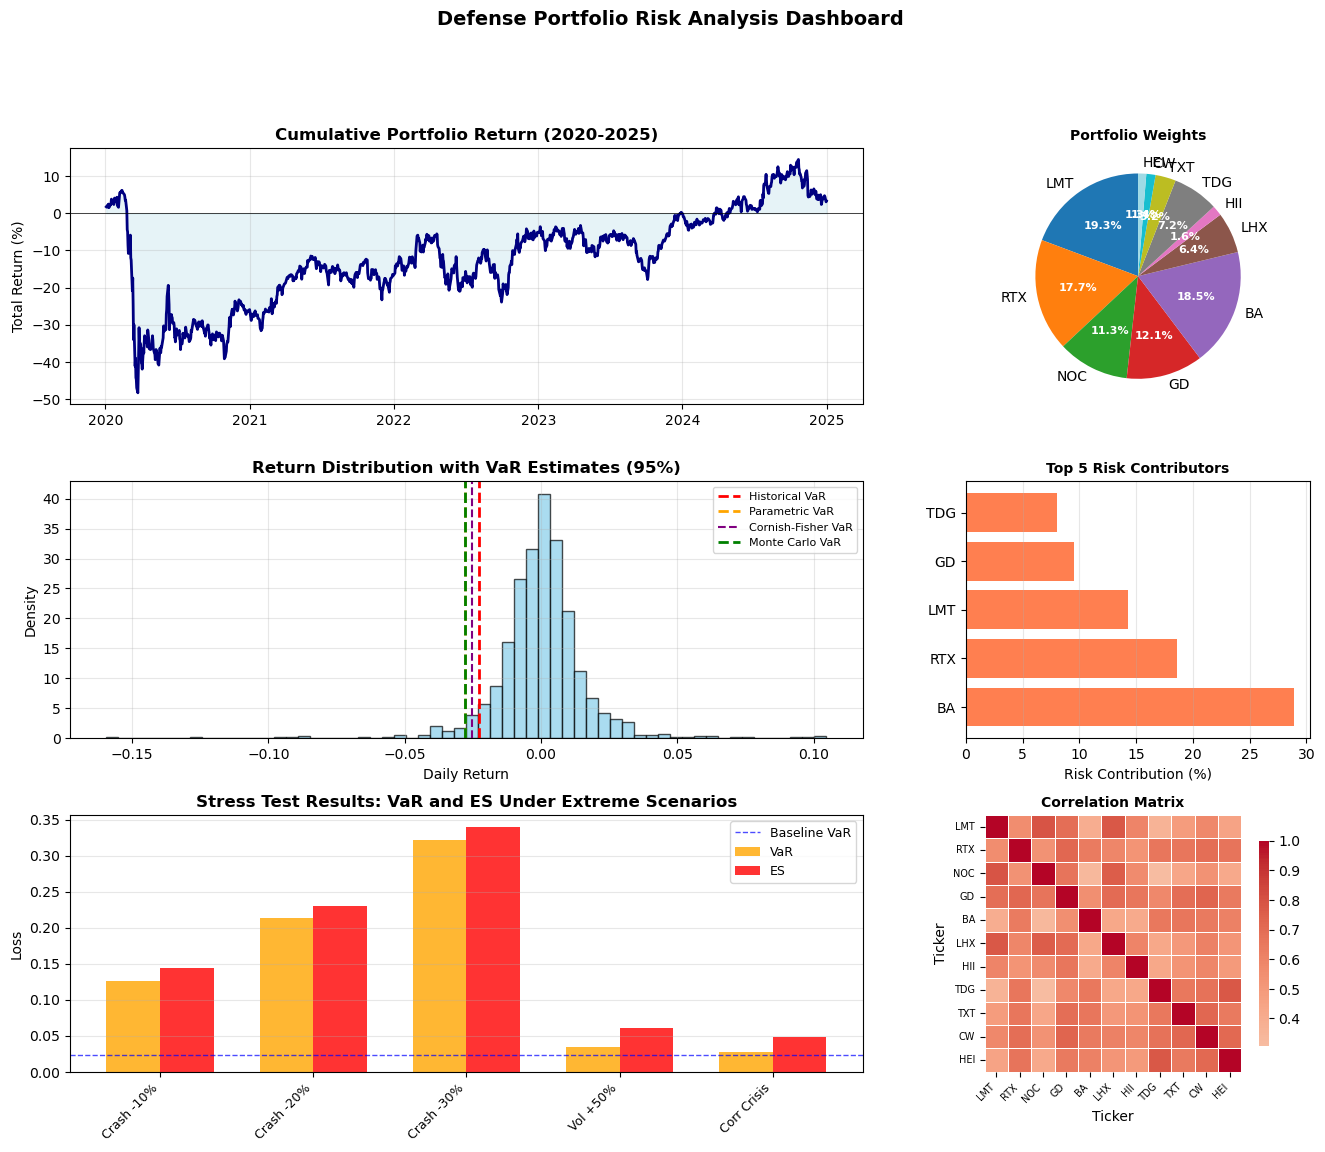

In [30]:
fig = plt.figure(figsize=(16, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

ax1 = fig.add_subplot(gs[0, :2])
cumulative_returns = (1 + portfolio_returns).cumprod() - 1
ax1.plot(cumulative_returns.index, cumulative_returns * 100, color='navy', linewidth=2)
ax1.fill_between(cumulative_returns.index, 0, cumulative_returns * 100, alpha=0.3, color='lightblue')
ax1.set_title('Cumulative Portfolio Return (2020-2025)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Total Return (%)')
ax1.grid(True, alpha=0.3)
ax1.axhline(0, color='black', linewidth=0.5)

ax2 = fig.add_subplot(gs[0, 2])
colors = plt.cm.tab20(np.linspace(0, 1, len(tickers)))
wedges, texts, autotexts = ax2.pie(weights, labels=tickers, autopct='%1.1f%%',
                                     colors=colors, startangle=90)
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(8)
    autotext.set_fontweight('bold')
ax2.set_title('Portfolio Weights', fontsize=10, fontweight='bold')

ax3 = fig.add_subplot(gs[1, :2])
ax3.hist(portfolio_returns, bins=60, color='skyblue', edgecolor='black', alpha=0.7, density=True)
ax3.axvline(-var_hist, color='red', linestyle='--', linewidth=2, label='Historical VaR')
ax3.axvline(-var_param, color='orange', linestyle='--', linewidth=2, label='Parametric VaR')
ax3.axvline(-var_cf, color='purple', linestyle='--', linewidth=1.5, label='Cornish-Fisher VaR')
ax3.axvline(-var_mc, color='green', linestyle='--', linewidth=2, label='Monte Carlo VaR')
ax3.set_title('Return Distribution with VaR Estimates (95%)', fontsize=12, fontweight='bold')
ax3.set_xlabel('Daily Return')
ax3.set_ylabel('Density')
ax3.legend(fontsize=8)
ax3.grid(True, alpha=0.3)

ax4 = fig.add_subplot(gs[1, 2])
top_contributors = sorted(zip(tickers, metrics['risk_contrib']), key=lambda x: x[1], reverse=True)[:5]
stocks, contribs = zip(*top_contributors)
bars = ax4.barh(stocks, contribs, color='coral')
ax4.set_xlabel('Risk Contribution (%)')
ax4.set_title('Top 5 Risk Contributors', fontsize=10, fontweight='bold')
ax4.grid(axis='x', alpha=0.3)

ax5 = fig.add_subplot(gs[2, :2])
scenario_names = list(stress_scenarios.keys())[1:]
vars_stress = [stress_scenarios[name][1] for name in scenario_names]
es_stress = [stress_scenarios[name][2] for name in scenario_names]
x = np.arange(len(scenario_names))
width = 0.35
ax5.bar(x - width/2, vars_stress, width, label='VaR', color='orange', alpha=0.8)
ax5.bar(x + width/2, es_stress, width, label='ES', color='red', alpha=0.8)
ax5.axhline(var_hist, color='blue', linestyle='--', linewidth=1, label='Baseline VaR', alpha=0.7)
ax5.set_ylabel('Loss')
ax5.set_title('Stress Test Results: VaR and ES Under Extreme Scenarios', fontsize=12, fontweight='bold')
ax5.set_xticks(x)
ax5.set_xticklabels(scenario_names, rotation=45, ha='right', fontsize=9)
ax5.legend(fontsize=9)
ax5.grid(axis='y', alpha=0.3)

ax6 = fig.add_subplot(gs[2, 2])
corr_matrix = returns.corr()
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8}, ax=ax6)
ax6.set_title('Correlation Matrix', fontsize=10, fontweight='bold')
ax6.set_xticklabels(ax6.get_xticklabels(), rotation=45, ha='right', fontsize=7)
ax6.set_yticklabels(ax6.get_yticklabels(), rotation=0, fontsize=7)

plt.suptitle('Defense Portfolio Risk Analysis Dashboard', fontsize=14, fontweight='bold', y=0.995)
plt.show()